In [1]:
%%javascript
require(["codemirror/keymap/sublime", "notebook/js/cell", "base/js/namespace"],
    function(sublime_keymap, cell, IPython) {
        cell.Cell.options_default.cm_config.keyMap = 'sublime';
        var cells = IPython.notebook.get_cells();
        for(var cl=0; cl< cells.length ; cl++){
            cells[cl].code_mirror.setOption('keyMap', 'sublime');
        }
    }
);

<IPython.core.display.Javascript object>

In [2]:
# change the cell width
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:85% !important; }</style>"))

In [3]:
# let's start with the super useful intro on how to extract a BED file with gene annotation from HiGlass docs ...
# https://docs.higlass.io/data_preparation.html#gene-annotation-tracks

In [4]:
ASSEMBLY="hg19"
TAXID=9606
DATADIR="./gene_annot_data"


### let's download some refseq, gene info and stuff

In [5]:
# %%bash
# DATADIR=./gene_annot_data
# mkdir -p $DATADIR
# mkdir -p $DATADIR/genbank
# wget -N -P $DATADIR ftp://ftp.ncbi.nlm.nih.gov/gene/DATA/gene2refseq.gz
# wget -N -P $DATADIR ftp://ftp.ncbi.nlm.nih.gov/gene/DATA/gene_info.gz
# wget -N -P $DATADIR ftp://ftp.ncbi.nlm.nih.gov/gene/DATA/gene2pubmed.gz


--2021-03-25 16:38:05--  ftp://ftp.ncbi.nlm.nih.gov/gene/DATA/gene2refseq.gz
           => ‘./gene_annot_data/.listing’
Resolving ftp.ncbi.nlm.nih.gov (ftp.ncbi.nlm.nih.gov)... 130.14.250.11, 130.14.250.13, 2607:f220:41f:250::228, ...
Connecting to ftp.ncbi.nlm.nih.gov (ftp.ncbi.nlm.nih.gov)|130.14.250.11|:21... connected.
Logging in as anonymous ... Logged in!
==> SYST ... done.    ==> PWD ... done.
==> TYPE I ... done.  ==> CWD (1) /gene/DATA ... done.
==> PASV ... done.    ==> LIST ... done.

     0K .                                                       171K=0.009s

2021-03-25 16:38:06 (171 KB/s) - ‘./gene_annot_data/.listing’ saved [1601]

Removed ‘./gene_annot_data/.listing’.
--2021-03-25 16:38:06--  ftp://ftp.ncbi.nlm.nih.gov/gene/DATA/gene2refseq.gz
           => ‘./gene_annot_data/gene2refseq.gz’
==> CWD not required.
==> PASV ... done.    ==> RETR gene2refseq.gz ... done.
Length: 1028166334 (981M)

     0K .......... .......... .......... .......... ..........  0%  388K 43m6

## Download data from UCSC and NCBI

In [18]:
%%bash -s "$ASSEMBLY" "$TAXID" "$DATADIR"
ASSEMBLY=$1
TAXID=$2
DATADIR=$3
# Download UCSC refGene database for assembly of interest
mkdir $DATADIR/$ASSEMBLY
wget -N -P $DATADIR/$ASSEMBLY/ http://hgdownload.cse.ucsc.edu/goldenPath/$ASSEMBLY/database/refGene.txt.gz

# Filter genbank data for species of interest
zcat $DATADIR/gene2refseq.gz | grep ^${TAXID} > $DATADIR/$ASSEMBLY/gene2refseq
zcat $DATADIR/gene_info.gz | grep ^${TAXID} | sort -k 2 > $DATADIR/$ASSEMBLY/gene_info # gene-centric
zcat $DATADIR/gene2pubmed.gz | grep ^${TAXID} > $DATADIR/$ASSEMBLY/gene2pubmed

# Sort
# Optional: filter out unplaced and unlocalized scaffolds (which have a "_" in the chrom name)
zcat $DATADIR/$ASSEMBLY/refGene.txt.gz \
    | awk -F $'\t' '{if (!($3 ~ /_/)) print;}' \
    | sort -k 2 \
    > $DATADIR/$ASSEMBLY/refGene_sorted
# not a BED-looking file - gene centric

--2021-03-25 16:49:11--  http://hgdownload.cse.ucsc.edu/goldenPath/hg19/database/refGene.txt.gz
Resolving hgdownload.cse.ucsc.edu (hgdownload.cse.ucsc.edu)... 128.114.119.163
Connecting to hgdownload.cse.ucsc.edu (hgdownload.cse.ucsc.edu)|128.114.119.163|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8043766 (7.7M) [application/x-gzip]
Saving to: ‘./gene_annot_data/hg19/refGene.txt.gz’

     0K .......... .......... .......... .......... ..........  0%  279K 28s
    50K .......... .......... .......... .......... ..........  1%  566K 21s
   100K .......... .......... .......... .......... ..........  1% 15.7M 14s
   150K .......... .......... .......... .......... ..........  2% 16.2M 10s
   200K .......... .......... .......... .......... ..........  3%  584K 11s
   250K .......... .......... .......... .......... ..........  3% 8.85M 9s
   300K .......... .......... .......... .......... ..........  4% 36.5M 8s
   350K .......... .......... .......... ......

## Get full model and citation count for each gene

In [21]:
%%bash -s  "$ASSEMBLY" "$TAXID" "$DATADIR"
ASSEMBLY=$1
TAXID=$2
DATADIR=$3
# Count pubmed citations
# Output: {gene_id} \t {citation_count}
cat $DATADIR/$ASSEMBLY/gene2pubmed \
    | awk '{print $2}' \
    | sort \
    | uniq -c \
    | awk '{print $2 "\t" $1}' \
    | sort \
    > $DATADIR/$ASSEMBLY/gene2pubmed-count

# Gene2refseq dictionary
# Output: {gene_id} \t {refseq_id}
cat $DATADIR/$ASSEMBLY/gene2refseq \
    | awk -F $'\t' '{ split($4,a,"."); if (a[1] != "-") print $2 "\t" a[1];}' \
    | sort \
    | uniq  \
    > $DATADIR/$ASSEMBLY/geneid_refseqid

# Append refseq IDs to citation count table
# Output: {gene_id} \t {refseq_id} \t {citation_count}
join $DATADIR/$ASSEMBLY/geneid_refseqid \
    $DATADIR/$ASSEMBLY/gene2pubmed-count  \
    | sort -k2 \
    > $DATADIR/$ASSEMBLY/geneid_refseqid_count

# Join the refseq gene model against gene IDs
# Output: {gene_id} \t {refseq_id} \t {chrom}(5) \t {strand}(6) \t {txStart}(7) \t {txEnd}(8) \t {cdsStart}(9) \t {cdsEnd}(10) \t {exonCount}(11) \t {exonStarts}(12) \t {exonEnds}(13)
join -1 2 -2 2 \
    $DATADIR/$ASSEMBLY/geneid_refseqid_count \
    $DATADIR/$ASSEMBLY/refGene_sorted \
    | awk '{ print $2 "\t" $1 "\t" $5 "\t" $6 "\t" $7 "\t" $8 "\t" $9 "\t" $10 "\t" $11 "\t" $12 "\t" $13 "\t" $3; }' \
    | sort -k1   \
    > $DATADIR/$ASSEMBLY/geneid_refGene_count

# Join citation counts against gene information
# output -> geneid \t symbol \t gene_type \t name \t citation_count
join -1 2 -2 1 -t $'\t' \
    $DATADIR/$ASSEMBLY/gene_info \
    $DATADIR/$ASSEMBLY/gene2pubmed-count \
    | awk -F $'\t' '{print $1 "\t" $3 "\t" $10 "\t" $12 "\t" $16}' \
    | sort -k1 \
    > $DATADIR/$ASSEMBLY/gene_subinfo_citation_count


join: ./gene_annot_data/hg19/geneid_refseqid:8: is not sorted: 10000	NM_001206729
join: ./gene_annot_data/hg19/gene2pubmed-count:94: is not sorted: 1000	345
join: input is not in sorted order
join: ./gene_annot_data/hg19/geneid_refseqid_count:554: is not sorted: 6166 NM_001001 44
join: ./gene_annot_data/hg19/refGene_sorted:1117: is not sorted: 967	NM_001001	chr14	-	50085247	50087344	50085501	50085822	2	50085247,50087279,	50085858,50087344,	0	RPL36AL	cmpl	cmpl	0,-1,
join: input is not in sorted order
join: ./gene_annot_data/hg19/gene_info:19: is not sorted: 9606	10000	AKT3	-	MPPH|MPPH2|PKB-GAMMA|PKBG|PRKBG|RAC-PK-gamma|RAC-gamma|STK-2	MIM:611223|HGNC:HGNC:393|Ensembl:ENSG00000117020	1	1q43-q44	AKT serine/threonine kinase 3	protein-coding	AKT3	AKT serine/threonine kinase 3	O	RAC-gamma serine/threonine-protein kinase|PKB gamma|RAC-gamma serine/threonine protein kinase|v-akt murine thymoma viral oncogene homolog 3 (protein kinase B, gamma)	20210302	-
join: ./gene_annot_data/hg19/gene2pubme

In [87]:
# ! head {DATADIR}/{ASSEMBLY}/geneid_refseqid
# ! head {DATADIR}/{ASSEMBLY}/geneid_refGene_count
! head {DATADIR}/{ASSEMBLY}/geneAnnotations.bed

chrX	49296745	49304144	GAGE12F	3	+	NM_001098405	100008586	protein-coding	G antigen 12F	49297934	49304050	49296745,49297926,49298483,49301426,49304027,	49296887,49298018,49298604,49301552,49304144,
chrX	49306301	49313700	GAGE12F	3	+	NM_001098405	100008586	protein-coding	G antigen 12F	49307490	49313606	49306301,49307482,49308039,49310982,49313583,	49306443,49307574,49308160,49311108,49313700,
chrX	49315857	49323252	GAGE12F	3	+	NM_001098405	100008586	protein-coding	G antigen 12F	49317046	49323158	49315857,49317038,49317595,49320538,49323135,	49315999,49317130,49317716,49320664,49323252,
chrX	49325410	49332811	GAGE12F	3	+	NM_001098405	100008586	protein-coding	G antigen 12F	49326599	49332717	49325410,49326591,49327148,49330097,49332694,	49325552,49326683,49327269,49330223,49332811,
chrX	49334968	49342360	GAGE12F	3	+	NM_001098405	100008586	protein-coding	G antigen 12F	49336157	49342266	49334968,49336149,49336706,49339650,49342243,	49335110,49336241,49336827,49339776,49342360,
chr11	69918539	

In [88]:
! head {DATADIR}/{ASSEMBLY}/geneAnnotationsExonUnions.bed

chrX	49296745	49304144	GAGE12F	3	+	union_100008586	100008586	protein-coding	G antigen 12F	49297934	49304050	49296745,49297926,49298483,49301426,49304027	49296887,49298018,49298604,49301552,49304144
chrX	49306301	49313700	GAGE12F	3	+	union_100008586	100008586	protein-coding	G antigen 12F	49307490	49313606	49306301,49307482,49308039,49310982,49313583	49306443,49307574,49308160,49311108,49313700
chrX	49315857	49323252	GAGE12F	3	+	union_100008586	100008586	protein-coding	G antigen 12F	49317046	49323158	49315857,49317038,49317595,49320538,49323135	49315999,49317130,49317716,49320664,49323252
chrX	49325410	49332811	GAGE12F	3	+	union_100008586	100008586	protein-coding	G antigen 12F	49326599	49332717	49325410,49326591,49327148,49330097,49332694	49325552,49326683,49327269,49330223,49332811
chrX	49334968	49342360	GAGE12F	3	+	union_100008586	100008586	protein-coding	G antigen 12F	49336157	49342266	49334968,49336149,49336706,49339650,49342243	49335110,49336241,49336827,49339776,49342360
chr11	6991

In [85]:
# !wget https://raw.githubusercontent.com/higlass/clodius/develop/scripts/exonU.py

In [24]:
%%bash -s  "$ASSEMBLY" "$TAXID" "$DATADIR"
ASSEMBLY=$1
TAXID=$2
DATADIR=$3
# 1: chr (chr1)
# 2: txStart (52301201) [9]
# 3: txEnd (52317145) [10]
# 4: geneName (ACVRL1)   [2]
# 5: citationCount (123) [16]
# 6: strand (+)  [8]
# 7: refseqId (NM_000020)
# 8: geneId (94) [1]
# 9: geneType (protein-coding)
# 10: geneDesc (activin A receptor type II-like 1)
# 11: cdsStart (52306258)
# 12: cdsEnd (52314677)
# 13: exonStarts (52301201,52306253,52306882,52307342,52307757,52308222,52309008,52309819,52312768,52314542,)
# 14: exonEnds (52301479,52306319,52307134,52307554,52307857,52308369,52309284,52310017,52312899,52317145,)
join -t $'\t' \
    $DATADIR/$ASSEMBLY/gene_subinfo_citation_count \
    $DATADIR/$ASSEMBLY/geneid_refGene_count \
    | awk -F $'\t' '{print $7 "\t" $9 "\t" $10 "\t" $2 "\t" $16 "\t" $8 "\t" $6 "\t" $1 "\t" $3 "\t" $4 "\t" $11 "\t" $12 "\t" $14 "\t" $15}' \
    > $DATADIR/$ASSEMBLY/geneAnnotations.bed

# Download: https://raw.githubusercontent.com/higlass/clodius/develop/scripts/exonU.py
# ! scp ghpcc:/nl/umw_job_dekker/cshare/reference/sorted_chromsizes/hg19.reduced.chrom.sizes ./
python exonU.py $DATADIR/$ASSEMBLY/geneAnnotations.bed > $DATADIR/$ASSEMBLY/geneAnnotationsExonUnions.bed

join: ./gene_annot_data/hg19/gene_subinfo_citation_count:130: is not sorted: 10009	ZBTB33	protein-coding	zinc finger and BTB domain containing 33	-
join: ./gene_annot_data/hg19/geneid_refGene_count:182: is not sorted: 10009	NM_001184742	chrX	+	119384666	119392253	119387270	119389289	3	119384666,119386523,119387268,	119384832,119386625,119392253,	99
join: input is not in sorted order


The first three required BED fields are:

 - **chrom** - The name of the chromosome (e.g. chr3, chrY, chr2_random) or scaffold (e.g. scaffold10671).
 - chromStart - The starting position of the feature in the chromosome or scaffold. The first base in a chromosome is numbered 0.
 - chromEnd - The ending position of the feature in the chromosome or scaffold. The chromEnd base is not included in the display of the feature, however, the number in position format will be represented. For example, the first 100 bases of chromosome 1 are defined as chrom=1, chromStart=0, chromEnd=100, and span the bases numbered 0-99 in our software (not 0-100), but will represent the position notation chr1:1-100. Read more here.


The 9 additional optional BED fields are:

 - name - Defines the name of the BED line. This label is displayed to the left of the BED line in the Genome Browser window when the track is open to full display mode or directly to the left of the item in pack mode.
 - score - A score between 0 and 1000. If the track line useScore attribute is set to 1 for this annotation data set, the score value will determine the level of gray in which this feature is displayed (higher numbers = darker gray).
 - strand - Defines the strand. Either "." (=no strand) or "+" or "-".
 - thickStart - The starting position at which the feature is drawn thickly (for example, the start codon in gene displays). When there is no thick part, thickStart and thickEnd are usually set to the chromStart position.
 - thickEnd - The ending position at which the feature is drawn thickly (for example the stop codon in gene displays).
 - itemRgb - An RGB value of the form R,G,B (e.g. 255,0,0). If the track line itemRgb attribute is set to "On", this RBG value will determine the display color of the data contained in this BED line. NOTE: It is recommended that a simple color scheme (eight colors or less) be used with this attribute to avoid overwhelming the color resources of the Genome Browser and your Internet browser.
 - blockCount - The number of blocks (exons) in the BED line.
 - blockSizes - A comma-separated list of the block sizes. The number of items in this list should correspond to blockCount.
 - blockStarts - A comma-separated list of block starts. All of the blockStart positions should be calculated relative to chromStart. The number of items in this list should correspond to blockCount.

In [5]:
! head -200 {DATADIR}/{ASSEMBLY}/geneAnnotationsExonUnions.bed

chrX	49296745	49304144	GAGE12F	3	+	union_100008586	100008586	protein-coding	G antigen 12F	49297934	49304050	49296745,49297926,49298483,49301426,49304027	49296887,49298018,49298604,49301552,49304144
chrX	49306301	49313700	GAGE12F	3	+	union_100008586	100008586	protein-coding	G antigen 12F	49307490	49313606	49306301,49307482,49308039,49310982,49313583	49306443,49307574,49308160,49311108,49313700
chrX	49315857	49323252	GAGE12F	3	+	union_100008586	100008586	protein-coding	G antigen 12F	49317046	49323158	49315857,49317038,49317595,49320538,49323135	49315999,49317130,49317716,49320664,49323252
chrX	49325410	49332811	GAGE12F	3	+	union_100008586	100008586	protein-coding	G antigen 12F	49326599	49332717	49325410,49326591,49327148,49330097,49332694	49325552,49326683,49327269,49330223,49332811
chrX	49334968	49342360	GAGE12F	3	+	union_100008586	100008586	protein-coding	G antigen 12F	49336157	49342266	49334968,49336149,49336706,49339650,49342243	49335110,49336241,49336827,49339776,49342360
chr11	6991

In [1]:
import bioframe
import pandas as pd
ddd = pd.read_csv("geneAnnotationsExonUnions.bed",sep="\t",header=None)

In [2]:
# ls /home/sergpolly/Desktop/ALV-repo/gene_annot_data/Housekeeping_GenesHuman.csv
!head ./gene_annot_data/Housekeeping_GenesHuman.csv

In [21]:
xxx = pd.read_csv("./gene_annot_data/HK_exons.csv")#.groupby("Chromosome").size()
# xxx[xxx["Gene Name"]=="M6PR"]
# "chromosome" "exon start" "exon end"
xxx = xxx.rename({"chromosome":"chrom","exon start":"start","exon end":"end"},axis=1)
xxx = xxx[["chrom","start","end"]].drop_duplicates().reset_index(drop=True)
xxx = xxx.sort_values(["chrom","start"]).reset_index(drop=True)
xxx.to_csv("HKexons.bed",header=None,index=False,sep="\t")
! bedToBigBed -tab -type=bed3 HKexons.bed hg19.sizes HKexons.bb

pass1 - making usageList (23 chroms): 4 millis
pass2 - checking and writing primary data (37363 records, 3 fields): 24 millis


In [37]:
xxx = pd.read_csv("./gene_annot_data/Housekeeping_TranscriptsHuman.csv",sep=";") \
        .rename({"Chromosome":"chrom","Start position":"start","End position":"end"},axis=1)
xxx = xxx[["chrom","start","end"]]
xxx["chrom"] = "chr"+xxx["chrom"].astype("str")
# "Chromosome","Start position","End position"
# ({"Chromosome":"chrom","Start position":"start","End position":"end"})
xxx = xxx.sort_values(["chrom","start"]).reset_index(drop=True)
xxx.to_csv("/home/sergpolly/Desktop/HKtrans.bed",header=None,index=False,sep="\t")
# xxx lifted to hg19 using whatever online tool ...

In [40]:
! bedSort ./gene_annot_data/HKtrans_hg19_downloaded.bed HKtrans_hg19.bed
! bedToBigBed -tab -type=bed3 HKtrans_hg19.bed hg19.sizes HKtrans.bb

pass1 - making usageList (23 chroms): 1 millis
pass2 - checking and writing primary data (2157 records, 3 fields): 5 millis


In [23]:
pd.read_csv("./gene_annot_data/Housekeeping_TranscriptsHuman.csv",sep=";")#.groupby("Chromosome").size()
HK_genes = pd.read_csv("./gene_annot_data/Housekeeping_GenesHuman.csv",sep=";")["Gene.name"].unique()

In [27]:
# ddd.loc[3]
aaa = ddd[ddd.iloc[:,3].isin(HK_genes)].reset_index(drop=True)
aaa.iloc[:,:3].to_csv("HKgenes.bed",index=False,header=None,sep="\t")
! bedToBigBed -tab -type=bed3 HKgenes.bed hg19.sizes HKgenes.bb
# aaa[maaa].iloc[:,:6].to_csv("protein-coding-genes-.bed",index=False,header=None,sep="\t")

pass1 - making usageList (24 chroms): 1 millis
pass2 - checking and writing primary data (1718 records, 3 fields): 2 millis


In [43]:
aaa = ddd[ddd[8] == "protein-coding"].copy()
aaa[4] = 1
paaa = (aaa[5] == "+")
maaa = (aaa[5] == "-")
aaa[paaa].iloc[:,:6].to_csv("protein-coding-genes+.bed",index=False,header=None,sep="\t")
aaa[maaa].iloc[:,:6].to_csv("protein-coding-genes-.bed",index=False,header=None,sep="\t")

In [44]:
# let's look at other types of transcripts separately !
aaa = ddd[ddd[8] != "protein-coding"].copy()
aaa[4] = 1
paaa = (aaa[5] == "+")
maaa = (aaa[5] == "-")
aaa[paaa].iloc[:,:6].to_csv("noncoding-genes+.bed",index=False,header=None,sep="\t")
aaa[maaa].iloc[:,:6].to_csv("noncoding-genes-.bed",index=False,header=None,sep="\t")

In [45]:
! wc -l protein-coding-genes+.bed
! wc -l protein-coding-genes-.bed
! wc -l noncoding-genes+.bed
! wc -l noncoding-genes-.bed

8590 protein-coding-genes+.bed
8295 protein-coding-genes-.bed
4045 noncoding-genes+.bed
3955 noncoding-genes-.bed


In [120]:
! bedToBigBed -tab -type=bed6 protein-coding-genes+.bed hg19.sizes pcgene_plus.bb
! bedToBigBed -tab -type=bed6 protein-coding-genes-.bed hg19.sizes pcgene_minus.bb

pass1 - making usageList (24 chroms): 2 millis
pass2 - checking and writing primary data (8590 records, 6 fields): 16 millis
pass1 - making usageList (24 chroms): 2 millis
pass2 - checking and writing primary data (8295 records, 6 fields): 16 millis


In [15]:
! bedToBigBed -tab -type=bed6 noncoding-genes+.bed hg19.sizes ncgene_plus.bb
! bedToBigBed -tab -type=bed6 noncoding-genes-.bed hg19.sizes ncgene_minus.bb

pass1 - making usageList (24 chroms): 2 millis
pass2 - checking and writing primary data (4045 records, 6 fields): 12 millis
pass1 - making usageList (25 chroms): 1 millis
pass2 - checking and writing primary data (3955 records, 6 fields): 7 millis


### Let's create a putative list of TSSs as well - beginning of +-genes and ends of --genes ...

In [3]:
aaa = ddd[ddd[8] == "protein-coding"].copy()
aaa[4] = 1
paaa = (aaa[5] == "+")
maaa = (aaa[5] == "-")
aaa[paaa].iloc[:,:6]
# .to_csv("protein-coding-genes+.bed",index=False,header=None,sep="\t")
# aaa[maaa].iloc[:,:6].to_csv("protein-coding-genes-.bed",index=False,header=None,sep="\t")

TSS1 = aaa[paaa].iloc[:,0:2].reset_index(drop=True).copy()
TSS1[2] = TSS1[1]+5
TSS1 = TSS1.drop_duplicates().reset_index(drop=True)
TSS1["strand"] = "+"


TSS2 = aaa[maaa].iloc[:,0:1].reset_index(drop=True).copy()
TSS2[1] = aaa[maaa].iloc[:,2].values-5
TSS2[2] = TSS2[1]+5
TSS2 = TSS2.drop_duplicates().reset_index(drop=True)
TSS2["strand"] = "-"


print(f"number of TSS+ {len(TSS1)}")
print(f"number of TSS- {len(TSS2)}")


TSSpc = pd.concat([TSS1,TSS2]).reset_index(drop=True).drop_duplicates()

print(f"combined of TSS {len(TSSpc)}, compare to {len(TSS1)+len(TSS2)}")

TSSpc.reset_index(drop=True).to_csv("pc-TSS.bed",index=False,header=None,sep="\t")


number of TSS+ 8368
number of TSS- 8097
combined of TSS 16465, compare to 16465


In [6]:
aaa = ddd[ddd[8] != "protein-coding"].copy()
aaa[4] = 1
paaa = (aaa[5] == "+")
maaa = (aaa[5] == "-")

TSS1 = aaa[paaa].iloc[:,0:2].reset_index(drop=True).copy()
TSS1[2] = TSS1[1]+5
TSS1 = TSS1.drop_duplicates().reset_index(drop=True)
TSS1["strand"] = "+"

TSS2 = aaa[maaa].iloc[:,0:1].reset_index(drop=True).copy()
TSS2[1] = aaa[maaa].iloc[:,2].values-5
TSS2[2] = TSS2[1]+5
TSS2 = TSS2.drop_duplicates().reset_index(drop=True)
TSS2["strand"] = "-"

print(f"number of TSS+ {len(TSS1)}")
print(f"number of TSS- {len(TSS2)}")

TSSnc = pd.concat([TSS1,TSS2]).reset_index(drop=True).drop_duplicates()

print(f"combined of TSS {len(TSSnc)}, compare to {len(TSS1)+len(TSS2)}")

TSSnc.reset_index(drop=True).to_csv("nc-TSS.bed",index=False,header=None,sep="\t")


number of TSS+ 3823
number of TSS- 3602
combined of TSS 7425, compare to 7425


In [7]:
print(f"number of TSS protein coding {len(TSSpc)}")
print(f"number of TSS non-coding {len(TSSnc)}")
TSS = pd.concat([TSSpc,TSSnc]).reset_index(drop=True).drop_duplicates()
print(f"combined of TSS {len(TSS)}, compare to {len(TSSpc)+len(TSSnc)}")
TSS.reset_index(drop=True).to_csv("allTSS.bed",index=False,header=None,sep="\t")

number of TSS protein coding 16465
number of TSS non-coding 7425
combined of TSS 23871, compare to 23890


### let's merge TSS with G4 peaks to defin all G4/transcription related locations ...

In [49]:
# bf is short for bioframe here ...
df = bioframe.read_table(
    "G4-Mao-sort",
    names=["chrom","start","end"]
)
df = df.sort_values(["chrom","start"])
df = df.reset_index(drop=True)
print(f"G4 ChipSeq peaks {len(df)}")
# bf is short for bioframe here ...
_df = pd.concat([TSS.rename({0:"chrom",1:"start",2:"end"},axis=1),df]).sort_values(["chrom","start"]).reset_index(drop=True)
bioframe.merge(_df, min_dist=1000)[["chrom","start","end"]].to_csv("union_G4_TSS.bed",header=None,index=False,sep="\t")
print(f"and the union list is {len(_df)} bs {len(df)+len(TSS)}")


G4 ChipSeq peaks 8955
and the union list is 32826 bs 32826


In [91]:
tss = TSS.rename({0:"chrom",1:"start",2:"end"},axis=1).copy()
# iii = np.arange(len(tss))
# np.random.shuffle(iii)
# tss.index = iii
# tss


In [93]:
bioframe.merge(tss, min_dist=10000)

,chrom,start,end,n_intervals
0,chr1,11868,17436,3
1,chr1,29365,36081,3
2,chr1,69090,69095,1
3,chr1,323891,323896,1
4,chr1,367658,367663,1
...,...,...,...,...
18704,chrY,59100402,59100407,1
18705,chrY,59214013,59214018,1
18706,chrY,59330366,59330371,1
18707,chrY,59349496,59349501,1


In [87]:
# bioframe.merge?
bioframe.merge(tss, min_dist=10000)

,chrom,start,end,n_intervals
0,chr1,11868,17436,3
1,chr1,29365,36081,3
2,chr1,69090,69095,1
3,chr1,323891,323896,1
4,chr1,367658,367663,1
...,...,...,...,...
18704,chrY,59100402,59100407,1
18705,chrY,59214013,59214018,1
18706,chrY,59330366,59330371,1
18707,chrY,59349496,59349501,1


In [69]:
bioframe.overlap(df,tss)

,chrom_1,start_1,end_1,chrom_2,start_2,end_2
0,chr1,713977,714310,chr1,714009,714014
1,chr1,762850,762982,chr1,762897,762902
2,chr1,762850,762982,chr1,762970,762975
3,chr1,935414,935699,chr1,935472,935477
4,chr1,994963,995114,chr1,995113,995118
...,...,...,...,...,...,...
9299,chrX,153775453,153775729,<NA>,<NA>,<NA>
9300,chrX,154255314,154255500,<NA>,<NA>,<NA>
9301,chrY,10033450,10033615,<NA>,<NA>,<NA>
9302,chrY,10037740,10037912,<NA>,<NA>,<NA>


In [70]:
!head union_G4_TSS.bed

chr1	11868	11878
chr1	17431	17436
chr1	29365	30370
chr1	36076	36081
chr1	69090	69095
chr1	323891	323896
chr1	367658	367663
chr1	564384	564389
chr1	568060	568065
chr1	622029	622034


In [38]:
! bedSort {DATADIR}/{ASSEMBLY}/geneAnnotationsExonUnions.bed geneAnnotationsExonUnions.bed

In [65]:
! cat geneAnnotationsExonUnions.bed |cut -f1-4 > justGenes.bed

In [90]:
! bedToBigBed -tab -type=bed4 justGenes.bed hg19.sizes hg19_annot.bb! head -3000 geneAnnotationsExonUnions.bed|tail

chr10	70173820	70231878	DNA2	55	-	union_1763	1763	protein-coding	DNA replication helicase/nuclease 2	70174795	70231621	70173820,70176463,70178790,70179559,70181981,70182271,70182453,70190192,70190192,70191613,70191962,70192150,70196767,70202673,70204677,70206052,70209784,70218860,70225423,70227879,70229737,70231547,70231547,70231810	70174862,70176612,70178970,70179649,70182186,70182361,70182647,70190297,70190412,70191728,70192072,70192267,70196998,70202868,70204840,70206170,70210004,70218992,70225569,70228063,70229920,70231642,70231730,70231878
chr10	70320093	70454242	TET1	164	+	union_80312	80312	protein-coding	tet methylcytosine dioxygenase 1	70332095	70451571	70320093,70331973,70360737,70404454,70411602,70412257,70426801,70432651,70441155,70442592,70446112,70450564	70320499,70334009,70360791,70406762,70411693,70412351,70427013,70432802,70441245,70442730,70446464,70454242
chr10	70480995	70552134	CCAR1	94	+	union_55749	55749	protein-coding	cell division cycle and apoptosis regulator 1	

In [66]:
! head justGenes.bed

chr1	11868	14362	DDX11L17
chr1	11873	14409	DDX11L1
chr1	14361	29370	WASH7P
chr1	17368	17436	MIR6859-4
chr1	17368	17436	MIR6859-1
chr1	17368	17436	MIR6859-3
chr1	17368	17436	MIR6859-2
chr1	30365	30503	MIR1302-11
chr1	30365	30503	MIR1302-10
chr1	30365	30503	MIR1302-9


In [67]:
! bedToBigBed -tab -type=bed4 justGenes.bed hg19.sizes hg19_annot.bb

pass1 - making usageList (25 chroms): 7 millis
pass2 - checking and writing primary data (24885 records, 4 fields): 40 millis


In [68]:
ls -lah hg19*

-rw-rw-r-- 1 sergpolly sergpolly 418K Mar 25 18:32 hg19_annot.bb
-rwxrwxr-x 1 sergpolly sergpolly  376 Mar 25 17:35 hg19.reduced.chrom.sizes*
-rw-rw-r-- 1 sergpolly sergpolly 2.0K Mar 25 17:54 hg19.sizes


In [42]:
#wget http://hgdownload.cse.ucsc.edu/admin/exe/linux.x86_64/bedToBigBed

In [22]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.print_figure_kwargs={'facecolor' : "w"}
import warnings
warnings.filterwarnings('ignore')
# import all relevant func and modules from a companion .py file
from supp_lib import *

In [70]:
bbi.info("hg19_annot.bb")

{'version': 4,
 'isCompressed': True,
 'isSwapped': 0,
 'primaryDataSize': 299451,
 'zoomLevels': 6,
 'chromCount': 25,
 'summary': {'basesCovered': 1157192927,
  'sum': 1246306033.0,
  'mean': 1.077007994017924,
  'min': 1.0,
  'max': 21.0,
  'std': 0.4987228052953744}}

In [115]:
bbi.fetch_intervals("hg19_annot.bb","chr1",40_000_000,40_200_000,iterator=False)

,chrom,start,end,name,score,strand
0,chr1,40026489,40042462,PABPC4,1,-
1,chr1,40089106,40105315,HEYL,1,-
2,chr1,40124792,40137710,NT5C1A,1,-
3,chr1,40144319,40157157,HPCAL4,1,-


In [114]:
bbi.fetch_intervals?

In [113]:
bbi.info("hg19_annot.bb")

{'version': 4,
 'isCompressed': True,
 'isSwapped': 0,
 'primaryDataSize': 212267,
 'zoomLevels': 5,
 'chromCount': 24,
 'summary': {'basesCovered': 1009255353,
  'sum': 1062351689.0,
  'mean': 1.052609417272023,
  'min': 1.0,
  'max': 21.0,
  'std': 0.45984559662229113}}

In [111]:
# bbi.fetch?
xxx = bbi.fetch(
    "hg19_annot.bb",
    "chr1",
    40_000_000,
    40_200_000,
    bins=-1,
    missing=0.0,
    oob=np.nan,
    summary='mean',
)


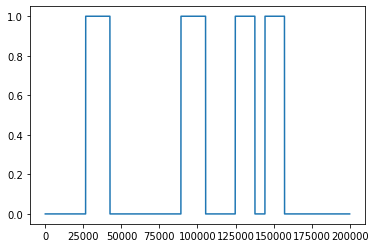

In [112]:
plt.plot(xxx)

In [77]:
!pwd

/home/sergpolly/Desktop/ALV-repo


In [8]:
! scp ghpcc:/nl/umw_job_dekker/users/av90w/projects/for-paper/for-higlass/AAVS1_sg24_NT_DDX55_sg2B_NT.output_events_all_select_hg19.txt ./
! scp ghpcc:/nl/umw_job_dekker/users/av90w/projects/for-paper/for-higlass/S44_NT_S442_IAA.output_events_all_select_hg19.txt ./

AAVS1_sg24_NT_DDX55_sg2B_NT.output_events_all 100%   79KB 825.7KB/s   00:00    
S44_NT_S442_IAA.output_events_all_select_hg19 100%   48KB 533.7KB/s   00:00    


In [ ]:
! bedSort {DATADIR}/{ASSEMBLY}/geneAnnotationsExonUnions.bed geneAnnotationsExonUnions.bed

In [14]:
! bedToBigBed

bedToBigBed v. 2.8 - Convert bed file to bigBed. (bbi version: 4)
usage:
   bedToBigBed in.bed chrom.sizes out.bb
Where in.bed is in one of the ascii bed formats, but not including track lines
and chrom.sizes is a two-column file/URL: <chromosome name> <size in bases>
and out.bb is the output indexed big bed file.
If the assembly <db> is hosted by UCSC, chrom.sizes can be a URL like
  http://hgdownload.soe.ucsc.edu/goldenPath/<db>/bigZips/<db>.chrom.sizes
or you may use the script fetchChromSizes to download the chrom.sizes file.
If you have bed annotations on patch sequences from NCBI, a more inclusive
chrom.sizes file can be found using a URL like
  http://hgdownload.soe.ucsc.edu/goldenPath/<db>/database/chromInfo.txt.gz
If not hosted by UCSC, a chrom.sizes file can be generated by running
twoBitInfo on the assembly .2bit file.
The in.bed file must be sorted by chromosome,start,
  to sort a bed file, use the unix sort command:
     sort -k1,1 -k2,2n unsorted.bed > sorted.bed
Sorting 

In [15]:
! bedSort AAVS1_sg24_NT_DDX55_sg2B_NT.output_events_all_select_hg19.txt SpliceDDX55aux.bed
! bedSort S44_NT_S442_IAA.output_events_all_select_hg19.txt SpliceCTCFaux.bed

In [16]:
! bedToBigBed -tab -type=bed3 SpliceDDX55aux.bed hg19.sizes SpliceDDX55aux.bb
! bedToBigBed -tab -type=bed3 SpliceCTCFaux.bed hg19.sizes SpliceCTCFaux.bb

pass1 - making usageList (23 chroms): 1 millis
pass2 - checking and writing primary data (3410 records, 3 fields): 5 millis
pass1 - making usageList (23 chroms): 1 millis
pass2 - checking and writing primary data (2079 records, 3 fields): 4 millis


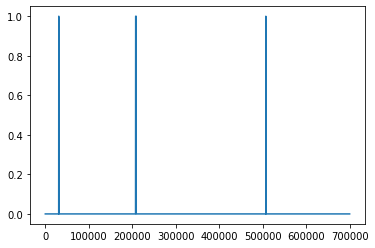

In [24]:
# bbi.fetch?
xxx = bbi.fetch(
    "SpliceDDX55aux.bb",
    "chr1",
    40_000_000,
    40_700_000,
    bins=-1,
    missing=0.0,
    oob=np.nan,
    summary='mean',
)
plt.plot(xxx)

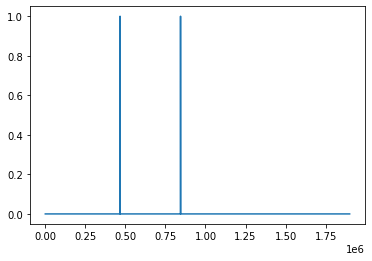

In [27]:
# bbi.fetch?
xxx = bbi.fetch(
    "SpliceCTCFaux.bb",
    "chr1",
    39_000_000,
    40_900_000,
    bins=-1,
    missing=0.0,
    oob=np.nan,
    summary='mean',
)
plt.plot(xxx)